In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sqlalchemy.orm import Session

from april.database import get_engine
from april.fs import PLOT_DIR
from april.utils import microsoft_colors
from april.utils import prettify_dataframe
from april.enums import Base, Heuristic, Axis

sns.set_style('white')
pd.set_option('display.max_rows', 20)
%config InlineBackend.figure_format = 'retina'

In [2]:
out_dir = PLOT_DIR / 'isj-2019'
eval_file = out_dir / 'eval.pkl'

### Helper objects

In [3]:
synth_datasets = ['paper', 'p2p', 'small', 'medium', 'large', 'huge', 'gigantic', 'wide']
bpic_datasets = ['bpic12', 'bpic13', 'bpic15', 'bpic17']
anonymous_datasets = ['real']
datasets = synth_datasets + bpic_datasets + anonymous_datasets
dataset_types = ['Synthetic', 'Real-life']

binet_ads = ["BINetv1", "BINetv2", "BINetv3"]
nn_ads = ["DAE"] + binet_ads
h_ads = nn_ads + [ "Likelihood+", "t-STIDE+", "Naive+"]
d_ads = ["Naive", "Sampling", "Likelihood", "OC-SVM"]
ads = h_ads + d_ads

heuristics = [r'$best$', r'$default$', r'$elbow_\downarrow$', r'$elbow_\uparrow$', 
              r'$lp_\leftarrow$', r'$lp_\leftrightarrow$', r'$lp_\rightarrow$']

## Retrieve evaluations from pickle file

In [4]:
evaluation = pd.read_pickle(eval_file)

### Add identifier for BPIC datasets and filter for ADs

In [5]:
evaluation = evaluation.query(f'ad in {ads} and label == "Anomaly"')

In [6]:
evaluation['perspective-label'] = evaluation['perspective'] + '-' + evaluation['label']
evaluation['attribute_name-label'] = evaluation['attribute_name'] + '-' + evaluation['label']
evaluation['dataset_type'] = 'Synthetic'
evaluation.loc[evaluation['process_model'].str.contains('bpic'), 'dataset_type'] = 'Real-life'
evaluation.loc[evaluation['process_model'].str.contains('real'), 'dataset_type'] = 'Real-life'

# Determine the Best Strategy

/home/timo.nolle/miniconda3/envs/ad/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


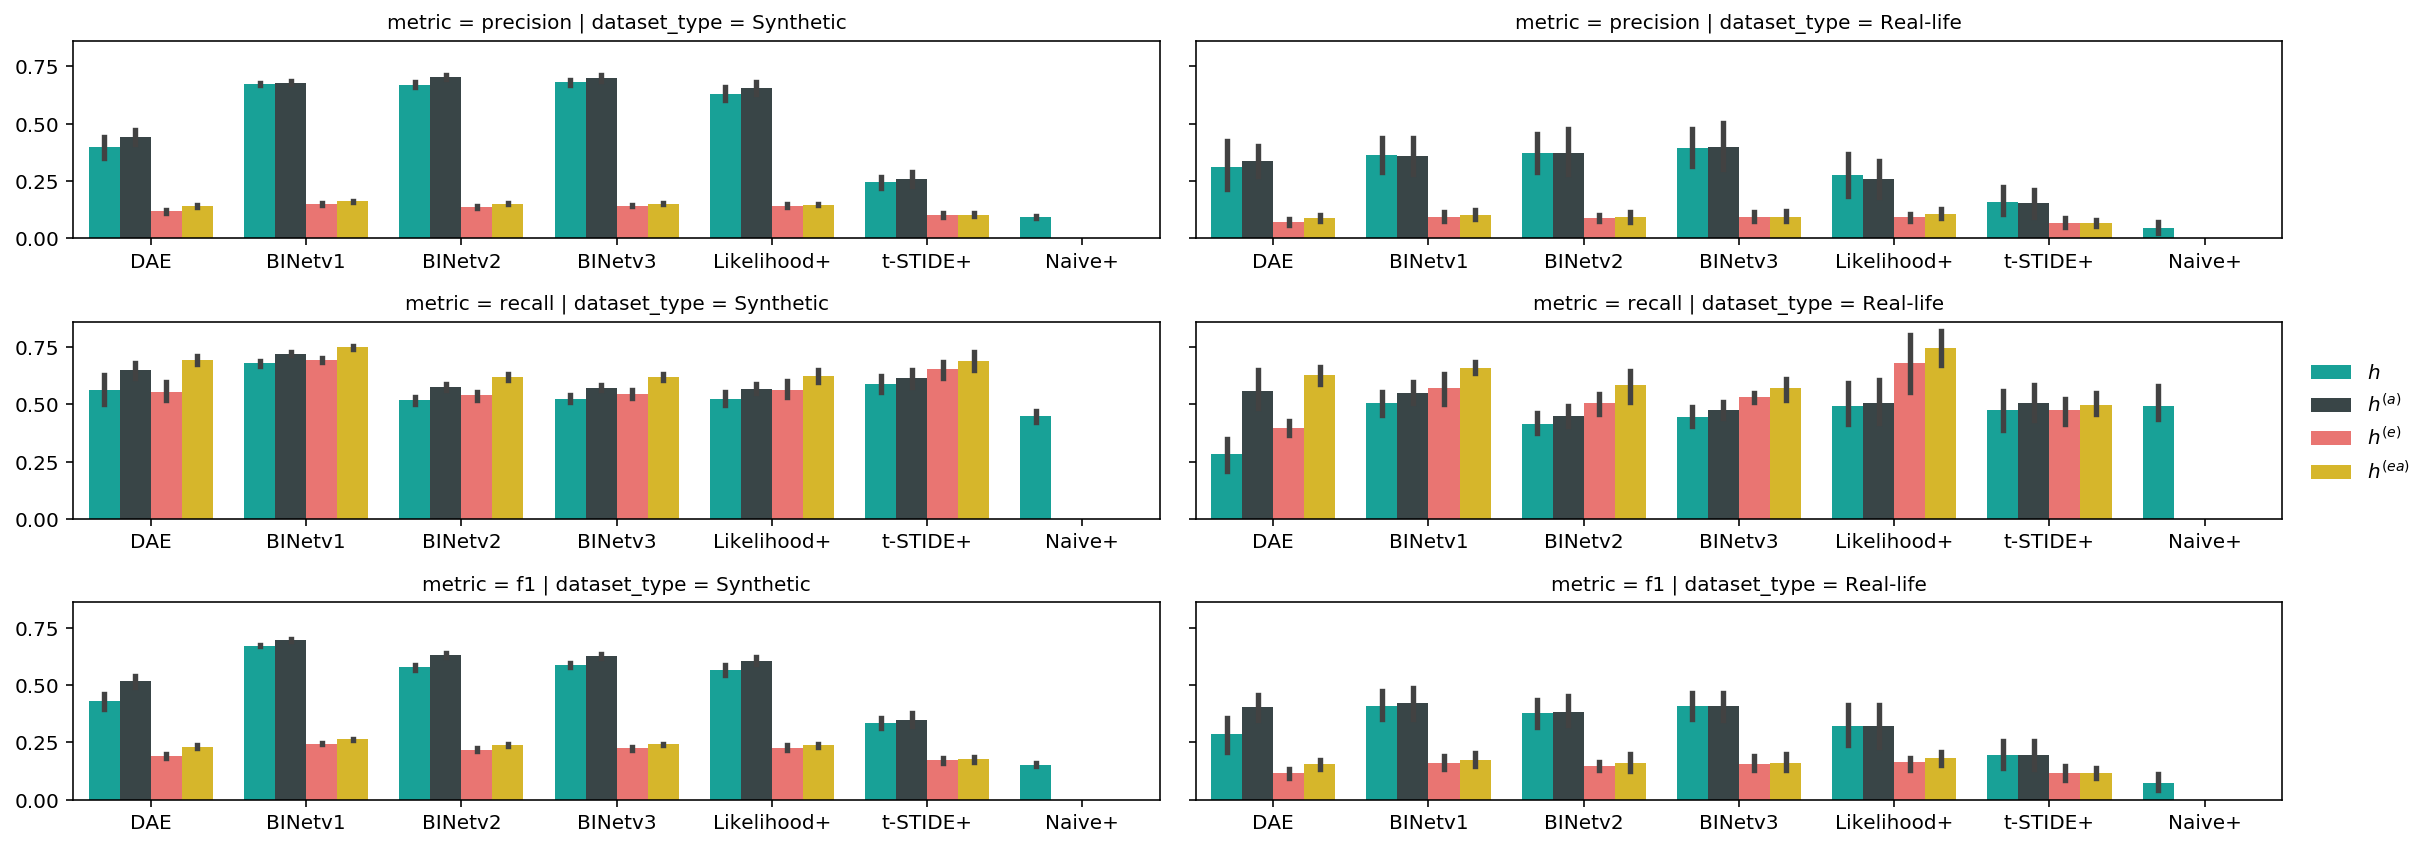

In [7]:
df = evaluation.query(f'heuristic == "{Heuristic.BEST}" and axis == {Axis.ATTRIBUTE}')
df = prettify_dataframe(df)
df = df.groupby(['dataset_type', 'strategy', 'ad', 'file_name', 'perspective', 'label'])['precision', 'recall', 'f1'].mean().reset_index()
df = df.groupby(['dataset_type', 'strategy', 'ad', 'file_name', 'perspective'])['precision', 'recall', 'f1'].mean().reset_index()
df = df.groupby(['dataset_type', 'strategy', 'ad', 'file_name'])['precision', 'recall', 'f1'].mean().reset_index()
df['f1'] = 2 * df['recall'] * df['precision'] / (df['recall'] + df['precision'])
df['f1'] = df['f1'].fillna(0)
df = df.melt(id_vars=['ad', 'strategy', 'dataset_type'], value_vars=['precision', 'recall', 'f1'], var_name='metric')
g = sns.FacetGrid(data=df, row='metric', col='dataset_type', sharex=False, sharey=True, despine=False, height=2, aspect=4, col_order=dataset_types)
g = g.map_dataframe(sns.barplot, x='ad', y='value', hue='strategy', palette=microsoft_colors, order=h_ads)
g = g.add_legend()

## Plot featured in the paper (Figure 8)

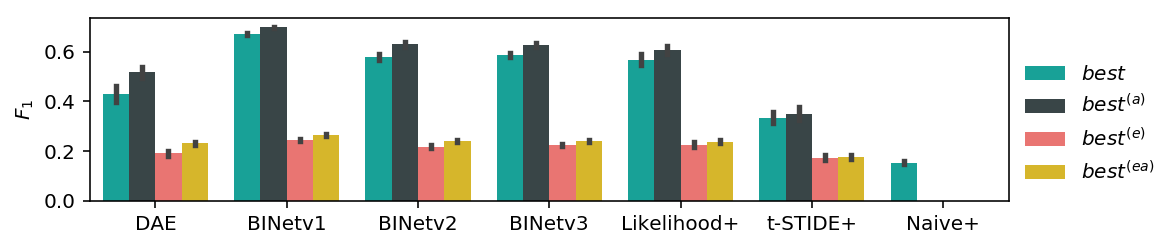

In [9]:
df = evaluation.query('heuristic == "best" and axis == 2 and dataset_type == "Synthetic"')
df = prettify_dataframe(df)
df = df.groupby(['dataset_type', 'strategy', 'ad', 'file_name', 'perspective', 'label'])['precision', 'recall', 'f1'].mean().reset_index()
df = df.groupby(['dataset_type', 'strategy', 'ad', 'file_name', 'perspective'])['precision', 'recall', 'f1'].mean().reset_index()
df = df.groupby(['dataset_type', 'strategy', 'ad', 'file_name'])['precision', 'recall', 'f1'].mean().reset_index()
df['f1'] = 2 * df['recall'] * df['precision'] / (df['recall'] + df['precision'])
df['f1'] = df['f1'].fillna(0)
df['strategy'] = df['strategy'].replace(r'h', r'best', regex=True)
g = sns.FacetGrid(data=df, row='dataset_type', sharex=False, sharey=True, despine=False, height=2, aspect=3.5)
g = g.map_dataframe(sns.barplot, x='ad', y='f1', hue='strategy', palette=microsoft_colors, order=h_ads)
g.add_legend()
_ = g.set(xlabel='', ylabel=r'$F_1$', title='')
g.savefig(str(out_dir / 'eval_strategies.pdf'))